This notebook checks if the gaps observed by Lane in resampled CGM data are present in the raw data as well. 

Dataset: DCLP3
Patient: 3
File: cgm_hisotry_transformed.csv
row_start = 21300
row_end = 22000

This was the matlab screenshot provided by lane  

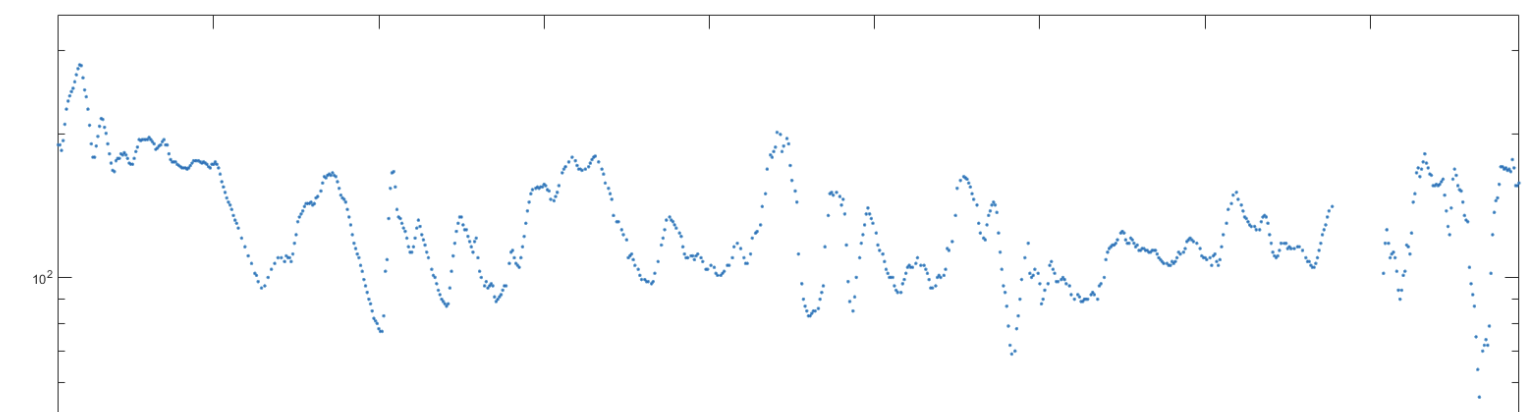

In [1]:
import os
import sys
%matplotlib inline
from matplotlib import pyplot as plt
sys.path.append(os.path.join(os.getcwd(), '..'))
from datetime import datetime, timedelta
import pandas as pd
from src import cdf
from src import postprocessing

## Compare to the raw data

2018-01-10 05:18:32 2018-07-18 20:07:40
2018-03-24 19:58:32 2018-03-27 22:58:32


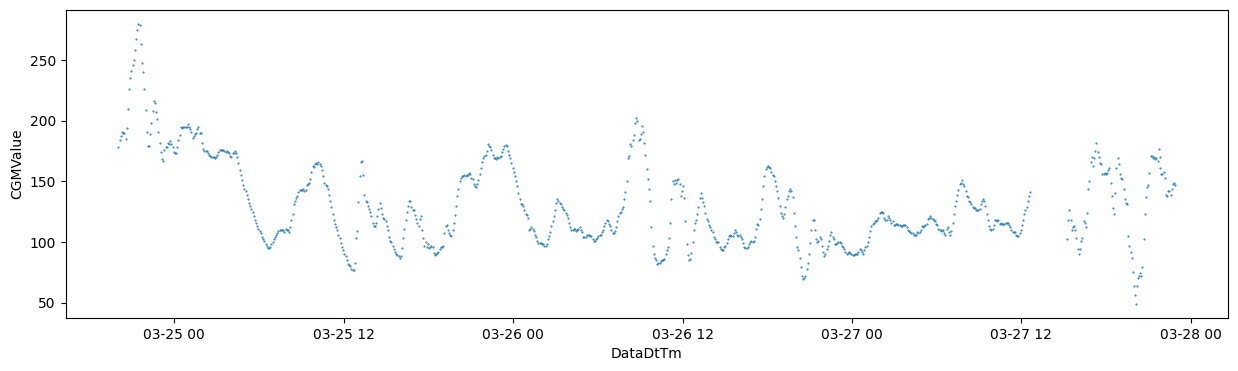

count    870.000000
mean       5.162874
std        5.142893
min        1.550000
25%        4.983333
50%        5.000000
75%        5.016667
max      156.566667
Name: DataDtTm, dtype: float64

In [2]:
#draw the region of interest in the raw data

#load raw data
cgm_file_path = os.path.join(os.getcwd(),'..','data','raw','DCLP3 Public Dataset - Release 3 - 2022-08-04/Data Files/Pump_CGMGlucoseValue.txt')
df_raw = pd.read_csv(cgm_file_path, sep='|', parse_dates=['DataDtTm','DataDtTm_adjusted'], date_format='%Y-%m-%d %H:%M:%S')

#select patient 3
df_patient = df_raw.loc[df_raw.PtID==3].copy()
df_patient = df_patient.set_index('DataDtTm').sort_values(by='DataDtTm') # don't forget to sort!
print(df_patient.index.min(), df_patient.index.max())

#select region of interest
row_start = 21200
row_end = 22100
datetime_start = df_patient.index.min() + timedelta(minutes=row_start*5)
datetime_end = df_patient.index.min() + timedelta(minutes=row_end*5)
print(datetime_start, datetime_end)
sub_frame = df_patient.loc[datetime_start: datetime_end].reset_index() #dont forget to sort! otherwise causes error

#scatter plot region
sub_frame.plot.scatter(y='CGMValue', x='DataDtTm',figsize=(15,4), marker='.', s=1)
plt.show()

diffs = sub_frame.reset_index().DataDtTm.diff().dt.total_seconds()/60
#plt.bar(x=sub_frame.DataDtTm,height=[1]*len(sub_frame), width=diffs, alpha=0.2, color='red')

#draw cdf
#f,ax = plt.figure(figsize=(15,3)), plt.gca()
#cdf.plot_cdf(diffs, title='Time between CGM values',ax=ax)
#plt.yscale('log')
#plt.show()

diffs.describe()

In [3]:
print(((diffs<=10) & (diffs>6)).sum())
print((diffs>10).sum())

0
1


## Comparing with resampled data
Now we resample the data and compare

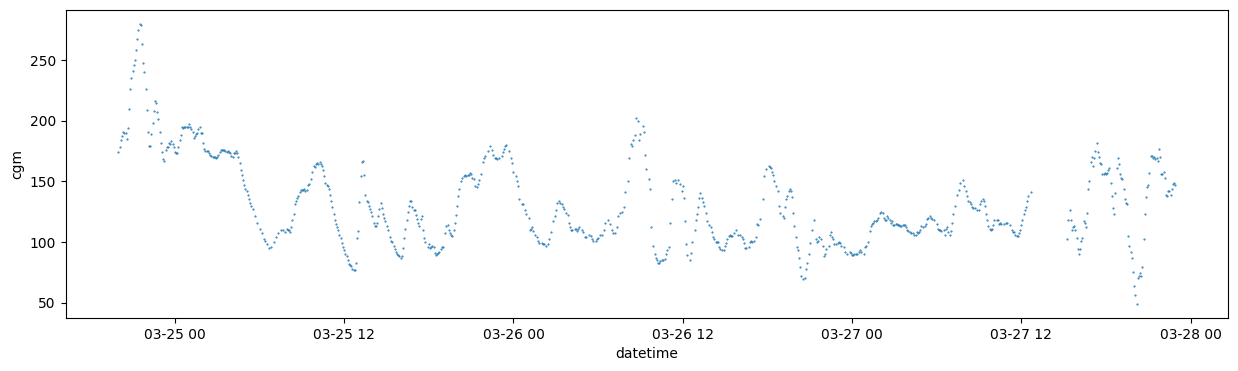

count    761.000000
mean       5.906702
std        5.686361
min        5.000000
25%        5.000000
50%        5.000000
75%        5.000000
max      155.000000
Name: datetime, dtype: float64

In [4]:
#extract and resample using dclp3 class, visualize data
from studies.dclp import DCLP3
from src import postprocessing

data_path = os.path.join(os.getcwd(),'..','data','raw')
dclp3 = DCLP3(os.path.join(data_path, 'DCLP3 Public Dataset - Release 3 - 2022-08-04',))
dclp3.load_data()

df_cgm = dclp3.extract_cgm_history()
df_patient = df_cgm.loc[df_cgm.patient_id=='3'].copy()
df_cgm_resampled = postprocessing.cgm_transform(df_patient)
df_cgm_resampled = df_cgm_resampled.set_index('datetime').sort_index()

sub_frame = df_cgm_resampled.loc[datetime_start: datetime_end].reset_index()
sub_frame.plot.scatter(y='cgm', x='datetime',figsize=(15,4), marker='.', s=1)
plt.show()
diffs = sub_frame.dropna(subset=['cgm']).datetime.diff().dt.total_seconds()/60
diffs.describe()

In [5]:
diffs.value_counts()

datetime
5.0      652
10.0     108
155.0      1
Name: count, dtype: int64

Visually the data looks almost identical however some gaps are visible. The large gap is present in all datasets. 

The postprocessed data also shows no gaps > 10 minutes, however the number of gaps ==10 minutes increases. This is likely a result of rounding to the closest 5 minute interval, that will increase the interval occasionally to 10 minutes.